## Import needed modules

In [2]:
import numpy as np
import script
import matplotlib.pyplot as plt
import cv2.cv as cv

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



In [3]:
# set up PathDicom - needed for functions
PathDicom = '/Volumes/Backup Data/ASDH Samples/Sample1/Post-operative/R-N11-109/HeadSpi  1.0  J40s  3'
# http://www.programcreek.com/python/example/65395/vtk.vtkThreshold
reload(script)
thresholded = script.threshim(0,50)
thresholded_np, ConstPixelSpacing = script.vtk2np(thresholded)
array = script.dicom2np()

In [4]:
x = np.arange(0.0, (thresholded_np.shape[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (thresholded_np.shape[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (thresholded_np.shape[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [5]:
script.heatmap(thresholded_np, 200, x, y)
script.heatmap(array,100,x,y)

# Find eyes for P-A direction

## Demonstrate how it works with one slice

In [6]:
import cv2
import matplotlib.image

matplotlib.image.imsave('img.png', thresholded_np[:,290,:]) 

img = cv2.imread('img.png')
img = cv2.resize(img, None, fx=ConstPixelSpacing[2]*2, fy=ConstPixelSpacing[1]*2)
img = cv2.medianBlur(img,3)
cimg= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [7]:
circles = cv2.HoughCircles(cimg,cv.CV_HOUGH_GRADIENT,1,50, 
                           param1=50,param2=30,minRadius=5,maxRadius=30)
# circles = np.uint16(np.around(circles))
try:
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
except:
    pass
# print circles

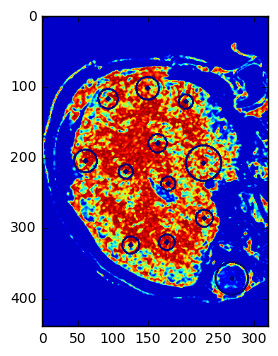

In [8]:
plt.clf()
plt.imshow(cimg)
# plt.axis('equal')
plt.show()

## Find circles across all slices

In [9]:
circles_data = np.zeros((thresholded_np.shape[1], 20, 3))

In [10]:
for i in range(thresholded_np.shape[1]):

    # to change dimension, change where i is 
    matplotlib.image.imsave('img.png', thresholded_np[:,i,:]) 

    img = cv2.imread('img.png')
    img = cv2.resize(img, None, fx=ConstPixelSpacing[2]*2, fy=ConstPixelSpacing[1]*2)
    img = cv2.medianBlur(img,3)
    cimg= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    circles = cv2.HoughCircles(cimg,cv.CV_HOUGH_GRADIENT,1,50, 
                           param1=50,param2=30,minRadius=5,maxRadius=30)
    try:
        circles_data[i,0:circles[0].shape[0],:] = circles[0]
    except:
        pass

## 3-D histogram on the circles data to find the densest regions

In [11]:
# hist_data is the same size as circles_data but has an additional column (for the explicit 
# slice number)
hist_data = np.zeros((circles_data.shape[0], circles_data.shape[1], circles_data.shape[2]+1))
# 1st, 2nd and 4th columns are circles_data for x, y and z
hist_data[:,:,0:2] = circles_data[:,:,0:2]
hist_data[:,:,3] = circles_data[:,:,2]

for i in range(hist_data.shape[0]):
    hist_data[:,:,2][i] = i # fill in the column of indices
hist_data = np.reshape(hist_data, [hist_data.shape[0]*hist_data.shape[1], hist_data.shape[2]])

In [12]:
# 3-D histogram of the x_coord, y_coord and slice number (first 3 cols of circle_data)
H, edges = np.histogramdd(hist_data[:, 0:3]) 

# remove all the data points on the axes 
H[0,:,:] = 0
H[:,0,:] = 0
H[:,:,0] = 0

In [13]:
flat_H = H.flatten()

mid_edges_x = np.zeros((len(edges[0])-1))
mid_edges_y = np.zeros((len(edges[1])-1))
mid_edges_z = np.zeros((len(edges[2])-1))

for i in range(len(mid_edges_x)):
    mid_edges_x[i] = (edges[0][i]+edges[0][i+1])/2
for i in range(len(mid_edges_y)):
    mid_edges_y[i] = (edges[1][i]+edges[1][i+1])/2
for i in range(len(mid_edges_z)):
    mid_edges_z[i] = (edges[2][i]+edges[2][i+1])/2

z = np.tile(mid_edges_z, len(mid_edges_y)*len(mid_edges_z))
y = np.tile(np.repeat(mid_edges_y, len(mid_edges_z)), len(mid_edges_x))
x = np.repeat(mid_edges_x, len(mid_edges_x)*len(mid_edges_y))

data = np.array([x,y,z,flat_H])

for i in range(data.shape[0]):
    data = np.array(data[:,data[i]!=0])

## Visualise the 3D histogram data - though this is not actually used for finding indicues

In [15]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

import numpy as np

trace1 = go.Scatter3d(
    x=data[0],
    y=data[1],
    z=data[2],
    mode='markers',
    marker=dict(
        size=5,
        color=data[3],           # set color to an array/list of desired values
        colorbar=go.ColorBar(
            title='Colorbar'
        ),
        colorscale='Viridis'
    )
)

trace = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
)
fig = go.Figure(data=trace, layout=layout)
py.offline.iplot(fig)

## Indices of densest regions

In [35]:
ind = np.dstack(np.unravel_index(np.argsort(H.ravel()), H.shape))
index_1 = ind[:,-1,:][0] # x, y, z indices of 1st eye socket 
index_2 = ind[:,-2,:][0] # x, y, z indices of 2nd eye socket

ranges_1 = np.array([[edges[0][index_1[0]], edges[0][index_1[0]+1]], 
                   [edges[1][index_1[1]], edges[1][index_1[1]+1]],
                   [edges[2][index_1[2]], edges[2][index_1[2]+1]]])
ranges_2 = np.array([[edges[0][index_2[0]], edges[0][index_2[0]+1]], 
                   [edges[1][index_2[1]], edges[1][index_2[1]+1]],
                   [edges[2][index_2[2]], edges[2][index_2[2]+1]]])
padding = 25

ranges_1 = ranges_1 + np.array([-padding, padding])
ranges_2 = ranges_2 + np.array([-padding, padding])

## Pick out data in the ranges

In [167]:
def mask_data(d, ranges):
    logicals = [d[j,0]>=ranges[0,0] and 
                d[j,0]<=ranges[0,1] and 
                d[j,1]>=ranges[1,0] and 
                d[j,1]<=ranges[1,1] and
                d[j,2]>=ranges[2,0] and 
                d[j,2]<=ranges[2,1]
                for j in range(d.shape[0])]
    e = np.array([np.multiply(d[:,j], logicals) for j in range(d.shape[1])])
    socket = np.array(e[:,e[1]!=0]) # columns are x,y,z,r
    return socket

socket_1 = mask_data(hist_data, ranges_1) 
socket_2 = mask_data(hist_data, ranges_2)

print socket_1.shape, socket_2.shape

def reject_outliers(data, m=3):
    data
    dx = np.abs(data[0] - np.median(data[0]))
    dy = np.abs(data[1] - np.median(data[1]))
    dz = np.abs(data[2] - np.median(data[3]))
    mdevx = np.median(dx)
    mdevy = np.median(dy)
    mdevz = np.median(dz)
    # if else is preventing from dividing by 0. if the median is 0, all
    # the differences have to be 0 becaues dx, dy, dz don't contain
    # negative numbers
    sx = dx/mdevx if mdevx else 0. 
    sy = dy/mdevy if mdevy else 0.
    sz = dz/mdevz if mdevz else 0.
    logicalx = sx<m
    logicaly = sy<m
    logicalz = sz<m
    e = data*logicalx*logicaly*logicalz
    data_return = np.array(e[:,e[1]!=0])
    return data_return

socket_1 = reject_outliers(socket_1)
socket_2 = reject_outliers(socket_2)

(4, 50) (4, 57)


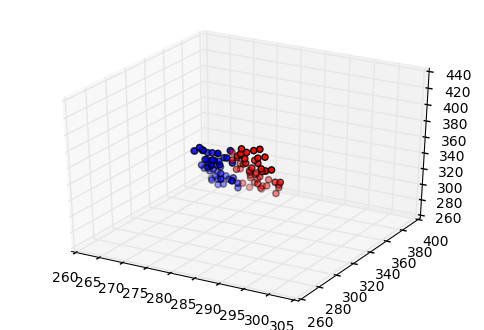

In [168]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.clf()
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
x1 = socket_1[0]
y1 = socket_1[1]
z1 = socket_1[2]
x2 = socket_2[0]
y2=socket_2[1]
z2=socket_2[2]
ax1.scatter(x1, y1, z1, c='r', marker='o')
ax1.scatter(x2, y2, z2, c='b', marker='o')
plt.show()

## relationship between x, y and z

In [252]:
import scipy
from scipy.optimize import curve_fit
import math
from math import floor

def f(xyz_data, A, B, C, D, E): 
    x = xyz_data[0]
    y = xyz_data[1]
    return A*x**2 + B*x + C*y**2 + D*y + E 
# initial_params = [0,0,0,0,0,0,0]
params1, pcov1 = curve_fit(f, socket_1[0:2], socket_1[2]) 
params2, pcov2 = curve_fit(f, socket_2[0:2], socket_2[2]) 
# put in initial_params if desired

## relationship between z and r

In [253]:
def max_z_r(socket):
    p = np.polyfit(socket[2], socket[3], deg=2)
    def f(z): return p[0]*z**2 + p[1]*z + p[2]
    max_z = scipy.optimize.fmin(lambda r: -f(r), 0)
    p = np.poly1d(p)
    max_r = p1(max_z)
    return max_z, max_r

maxz1, maxr1 = max_z_r(socket_1)
maxz2, maxr2 = max_z_r(socket_2)

Optimization terminated successfully.
         Current function value: -22.847932
         Iterations: 42
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -22.569654
         Iterations: 41
         Function evaluations: 82


## find x and y coordinates of maximum from the z coordinate

In [ ]:
def f1
scipy.optimize.fsolve

In [251]:
xx1, yy1 = np.mgrid[floor(min(socket_1[0])): ceil(max(socket_1[0])),
        floor(min(socket_1[1])): ceil(max(socket_1[1]))]

xx2, yy2 = np.mgrid[floor(min(socket_2[0])): ceil(max(socket_2[0])),
        floor(min(socket_2[1])): ceil(max(socket_2[1]))]

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

import numpy as np
A,B,C,D,E = params1
z1=A*xx1**2 + B*xx1 + C*yy1**2 + D*yy1 + E 
A,B,C,D,E = params2
z2=A*xx2**2 + B*xx2 + C*yy2**2 + D*yy2 + E 

surface1 = go.Surface(
x = xx1,
y = yy1,
z = z1,
opacity = 0.99
)

scatter1 = go.Scatter3d(
x = socket_1[0],
y = socket_1[1],
z = socket_1[2],
mode = 'markers',
marker=dict(
    size=2)
)

surface2 = go.Surface(
x = xx2,
y = yy2,
z = z2,
opacity = 0.99
)

scatter2 = go.Scatter3d(
x = socket_2[0],
y = socket_2[1],
z = socket_2[2],
mode = 'markers',
marker=dict(
    size=2)
)

layout = go.Layout(
    title='Plane through coordinates of eyes',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=[surface1,scatter1], layout=layout)
py.offline.iplot(fig)
fig = go.Figure(data=[surface2,scatter2], layout=layout)
py.offline.iplot(fig)